## A notebook for fitting to ARMADA binary orbits

In [34]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import random
from tqdm import tqdm
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
import emcee
import corner
from read_data import read_data,read_wds,read_orb6
from astrometry_model import astrometry_model,lnlike,lnprior,lnpost,create_init
from orbit_plotting import orbit_model
%matplotlib inline

In [35]:
if os.getcwd()[7:14] == 'tgardne':
    ## setup paths for user
    path = '/Users/tgardne/ARMADA_orbits'
    path_etalon = '/Users/tgardne/etalon_epochs/etalon_fits/etalon_factors_fit_SKY.txt'
    path_wds = '/Users/tgardne/wds_targets'
    path_orb6 = '/Users/tgardne/catalogs/orb6orbits.sql.txt'
    
elif os.getcwd()[7:19] == 'adam.scovera':
    ## Adam's path
    path = '/Users/adam.scovera/Documents/UofM/BEPResearch/armada_binaries/Data/ARMADA_orbits'
    path_etalon = '/Users/adam.scovera/Documents/UofM/BEPResearch/armada_binaries/Data/etalon_factors_fit.txt'
    path_wds = '/Users/adam.scovera/Documents/UofM/BEPResearch/armada_binaries/Data/wds_targets'
    path_orb6 = '/Users/adam.scovera/Documents/UofM/BEPResearch/armada_binaries/Data/orb6orbits.sql.txt'

## Specify a target HD number and WDS number

In [121]:
### give target information
# target is hip number
# target_hd is hd number
# target_wds is wds number

target = []
target_hd = []
target_wds = []

# Target 0
target.append('26536')
target_hd.append ('37269')
target_wds.append('05386+3030')

# Target 1
target.append('21644')
target_hd.append ('29573')
target_wds.append('04389-1207')

# Target 2 Has some problems
target.append('12828')
target_hd.append ('17094')
target_wds.append('02449+1007')

# Target 3
target.append('101398')
target_hd.append ('196089')
target_wds.append('20330+4950')

# Target 4
target.append('98055')
target_hd.append ('189037')
target_wds.append('19556+5226')

# Target 5
target.append('21730')
target_hd.append ('29316')
target_wds.append('04400+5328')

# Target 6
target.append('26777')
target_hd.append ('37711')
target_wds.append('05413+1632')

# Target 7
target.append('113788')
target_hd.append ('217782')
target_wds.append('23026+4245')

# Target 8
target.append('5131')
target_hd.append ('6456')
target_wds.append('01057+2128')

# Target 9
target.append('12466')
target_hd.append('16753')
target_wds.append('02405-2408')

# Choose which index to focus on
focus = 0

## Read in ARMADA data

In [122]:
#Get data from txt file:
file=open('%s/HD_%s.txt'%(path,target_hd[focus]))
weight=1

t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

## Apply Etalon Correction

In [123]:
## get etalon factors from txt file fit
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

   date      etalon factor
58798.3984 0.9999400104643138
58769.4589 0.9998462880171332
58835.3424 0.999986762742842
58702.5166 0.9998651669612845
58381.4865 0.9996143351010733
58024.4319 1.0009147628336739
58351.5011 1.0030746436511166
58413.4478 0.9986398379023541
58456.3202 0.9981681851388633
58443.3875 0.9986827255038921


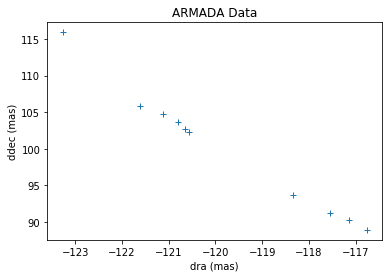

In [124]:
## apply etalon correction
#etalon_factor=1
p = p/etalon_factor

xpos=p*np.sin(theta)
ypos=p*np.cos(theta)

plt.plot(xpos,ypos,'+')
plt.title('ARMADA Data')
plt.xlabel('dra (mas)')
plt.ylabel('ddec (mas)')
plt.show()

## Read in WDS data

In [125]:
## get wds data
#Get data from txt file:
file=open(os.path.expanduser("%s/wds%s.txt"%(path_wds,target_wds[focus])))
weight = 10
dtype = 'S'

t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_wds(file,weight,dtype)

In [126]:
print(len(p_wds))

31


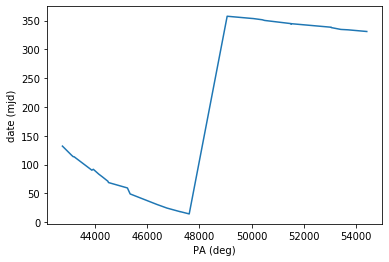

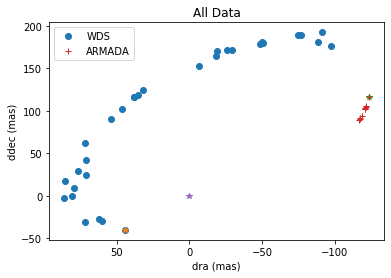

In [127]:
## plot all data
    
if target_hd[focus] == '17094':
    idx = np.where(theta_wds*180/np.pi>180)
    theta_wds[idx]-=np.pi
    plt.plot(t_wds,theta_wds*180/np.pi)
    plt.show()
    
else:
    plt.plot(t_wds,theta_wds*180/np.pi)
    plt.xlabel('PA (deg)')
    plt.ylabel('date (mjd)')
    plt.show()

xpos_wds=p_wds*np.sin(theta_wds)
ypos_wds=p_wds*np.cos(theta_wds)

idx = np.argmin(t)

plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
plt.plot(xpos_wds[0],ypos_wds[0],'*')
plt.plot(xpos[idx],ypos[idx],'*')
plt.plot(xpos,ypos,'+',label='ARMADA')
plt.plot(0,0,'*')
plt.gca().invert_xaxis()
plt.title('All Data')
plt.xlabel('dra (mas)')
plt.ylabel('ddec (mas)')
plt.legend()
plt.show()

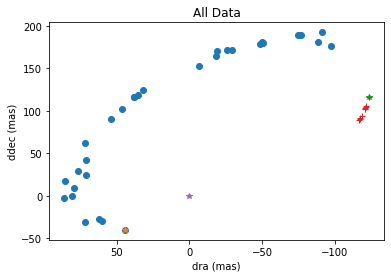

In [128]:
## flip WDS by 180???
if target_hd[focus] == '17094':
    xpos_wds=-p_wds*np.sin(theta_wds)
    ypos_wds=-p_wds*np.cos(theta_wds)

plt.plot(xpos_wds,ypos_wds,'o')
plt.plot(xpos_wds[0],ypos_wds[0],'*')
plt.plot(xpos[idx],ypos[idx],'*')
plt.plot(xpos,ypos,'+')
plt.plot(0,0,'*')
plt.gca().invert_xaxis()
plt.title('All Data')
plt.xlabel('dra (mas)')
plt.ylabel('ddec (mas)')
plt.show()

## Get an estimate of the orbital parameters

In [129]:
if target_hd[focus] == '17094':
    # Guess for hd17094
    P = 33*365
    e = 0.9
    inc = 264*np.pi/180
    omega = 260*np.pi/180
    bigomega = 240*np.pi/180
    a = 540
    T = 21870.8
    
else:
    a,P,e,inc,omega,bigomega,T = read_orb6(target[focus],path_orb6)

found target!
--------------------------
a(mas),P(yr),e,i(deg),omega(deg),bigomega(deg),T(mjd)
154.0 52.73500000000001 0.653 124.22000000000001 309.07000000000005 127.07999999999998 42386.31231940002
--------------------------


## Combine the ARMADA and WDS data for fitting

In [130]:
## add all data together
xpos_all = np.concatenate([xpos,xpos_wds])
ypos_all = np.concatenate([ypos,ypos_wds])
t_all = np.concatenate([t,t_wds])

error_maj_all = np.concatenate([error_maj,error_maj_wds])
error_min_all = np.concatenate([error_min,error_min_wds])
error_pa_all = np.concatenate([error_pa,error_pa_wds])
error_deg_all = np.concatenate([error_deg,error_deg_wds])

## First, do a least-squares fit

In [131]:
#create a set of Parameters, choose starting value and range for search
params = Parameters()
params.add('w',   value= omega, min=0, max=2*np.pi)
params.add('bigw', value= bigomega, min=0, max=2*np.pi)
params.add('inc', value= inc, min=0, max=2*np.pi)
params.add('e', value= e, min=0, max=0.99)
params.add('a', value= a, min=0)
params.add('P', value= P, min=0)
params.add('T', value= T, min=0)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
minner = Minimizer(astrometry_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                       error_maj_all,error_min_all,
                                                       error_pa_all))
kws  = {'options': {'maxiter':10}}
result = minner.minimize()

# write error report
print(report_fit(result))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 82
    # variables        = 7
    chi-square         = 23.3055679
    reduced chi-square = 0.31074090
    Akaike info crit   = -89.1582100
    Bayesian info crit = -72.3111753
[[Variables]]
    w:     5.45700930 +/- 0.03071995 (0.56%) (init = 5.394289)
    bigw:  2.26781925 +/- 0.02346418 (1.03%) (init = 2.217964)
    inc:   2.19383687 +/- 0.00562141 (0.26%) (init = 2.168048)
    e:     0.62577570 +/- 0.01277298 (2.04%) (init = 0.653)
    a:     148.364450 +/- 0.63881609 (0.43%) (init = 154)
    P:     19427.6955 +/- 140.994082 (0.73%) (init = 19248.28)
    T:     42285.5234 +/- 73.3921630 (0.17%) (init = 42386.31)
[[Correlations]] (unreported correlations are < 0.100)
    C(bigw, e) = -0.973
    C(w, bigw) =  0.972
    C(e, P)    = -0.959
    C(bigw, P) =  0.919
    C(P, T)    = -0.907
    C(w, e)    = -0.893
    C(w, P)    =  0.819
    C(w, a)    = -0.788
    C(e, T)    =  0.776
 

In [132]:
resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                 error_min,error_pa)
resids_wds = astrometry_model(result.params,xpos_wds,ypos_wds,t_wds,
                              error_maj_wds,error_min_wds,error_pa_wds)

ndata_armada = 2*sum(~np.isnan(xpos))
ndata_wds = 2*sum(~np.isnan(xpos_wds))

chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-len(result.params))
chi2_wds = np.nansum(resids_wds**2)/(ndata_wds-len(result.params))

print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)
print('chi2 wds = %s'%chi2_wds)
print('-'*10)

----------
chi2 armada = 1.2668461544485425
----------
chi2 wds = 0.12430123374923992
----------


## Take a look at the least squares fit

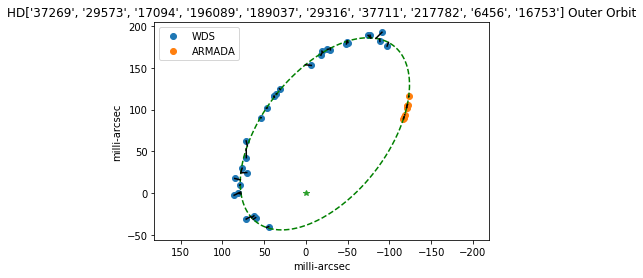

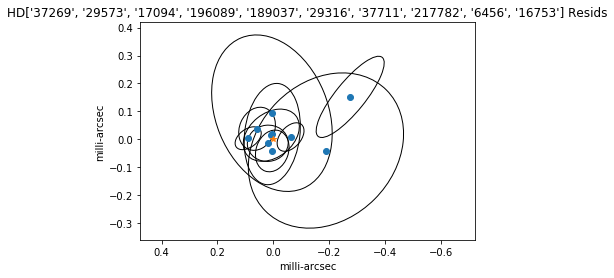

----------
Mean residual = 65.84 micro-as
----------


In [133]:
scale=1
if chi2_armada<1.0:
    scale=1/np.sqrt(chi2_armada)

a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
#pscale_start = result.params['pscale']

ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)

fig,ax=plt.subplots()

ax.plot(xpos_wds, ypos_wds, 'o', label='WDS')
ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')

#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1

directory='%s/HD%s/'%(path,target_hd)
if not os.path.exists(directory):
    os.makedirs(directory)
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s/HD%s_outer_leastsquares.pdf'%(path,target_hd,target_hd))
plt.show()

## plot resids for ARMADA
fig,ax=plt.subplots()
xresid = xpos - rapoints[:len(xpos)]
yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

ax.plot(xresid, yresid, 'o')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.savefig('%s/HD%s/HD%s_resid_leastsquares.pdf'%(path,target_hd,target_hd))
plt.show()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

In [138]:
target_hd_str = target_hd[focus]
print(target_hd_str)

## write a txt file output with best orbit
f = open("%s/HD%s/%s_orbit_ls.txt"%(path,target_hd_str,target_hd_str),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s"%(P_start.value,a_start.value,e_start.value,
                                   inc_start.value*180/np.pi,w_start.value*180/np.pi,
                                   bigw_start.value*180/np.pi,T_start.value,
                                  resids_median))
f.close()

37269


FileNotFoundError: [Errno 2] No such file or directory: '/Users/adam.scovera/Documents/UofM/BEPResearch/armada_binaries/Data/ARMADA_orbits/HD37269/37269_orbit_ls.txt'

## Now Do a Full MCMC

In [ ]:
initial_params = [w_start,bigw_start,inc_start,e_start,a_start,P_start,T_start]
nDim = len(initial_params)
nWalkers = 2*nDim
init = [create_init(initial_params) for i in range(nWalkers)]
sampler = emcee.EnsembleSampler(nWalkers, nDim, lnpost,args=[xpos_all,ypos_all,t_all,error_maj_all,error_min_all,error_pa_all])
sampler.run_mcmc(init, 1000000, progress=True)

## Take a look at our walkers

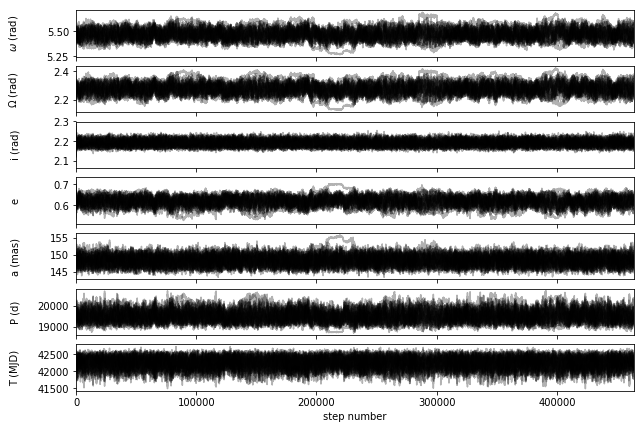

In [16]:
fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels=["$\omega$ (rad)","$\Omega$ (rad)","i (rad)","e","a (mas)","P (d)","T (MJD)"]
for i in range(nDim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

plt.savefig('%s/HD%s/HD%s_chains.pdf'%(path,target_hd,target_hd))
plt.show()

## Estimate autocorrelation time - did we run with enough steps?

In [17]:
try:
    tau = sampler.get_autocorr_time()
    print('tau = ')
    print(tau)
    print(10*'-')

    burn = int(3*np.mean(tau))
    print('burn = ')
    print(burn)
    print(10*'-')

    thin = int(np.mean(tau)/2)
    print('thin = ')
    print(thin)
    print(10*'-')
except:
    print('did not run long enough!!!')
    burn = 100
    thin = 10

/usr/local/anaconda/envs/python3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


tau = 
[5913.694131   6095.86220283 1206.78212397 5927.52759894 2908.74408807
 5291.5880541  2867.38185076]
----------
burn = 
12947
----------
thin = 
2157
----------


## Apply a burn-in period, and thin the chain

In [18]:
flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
print(flat_samples.shape)

(2926, 7)


## Corner plot

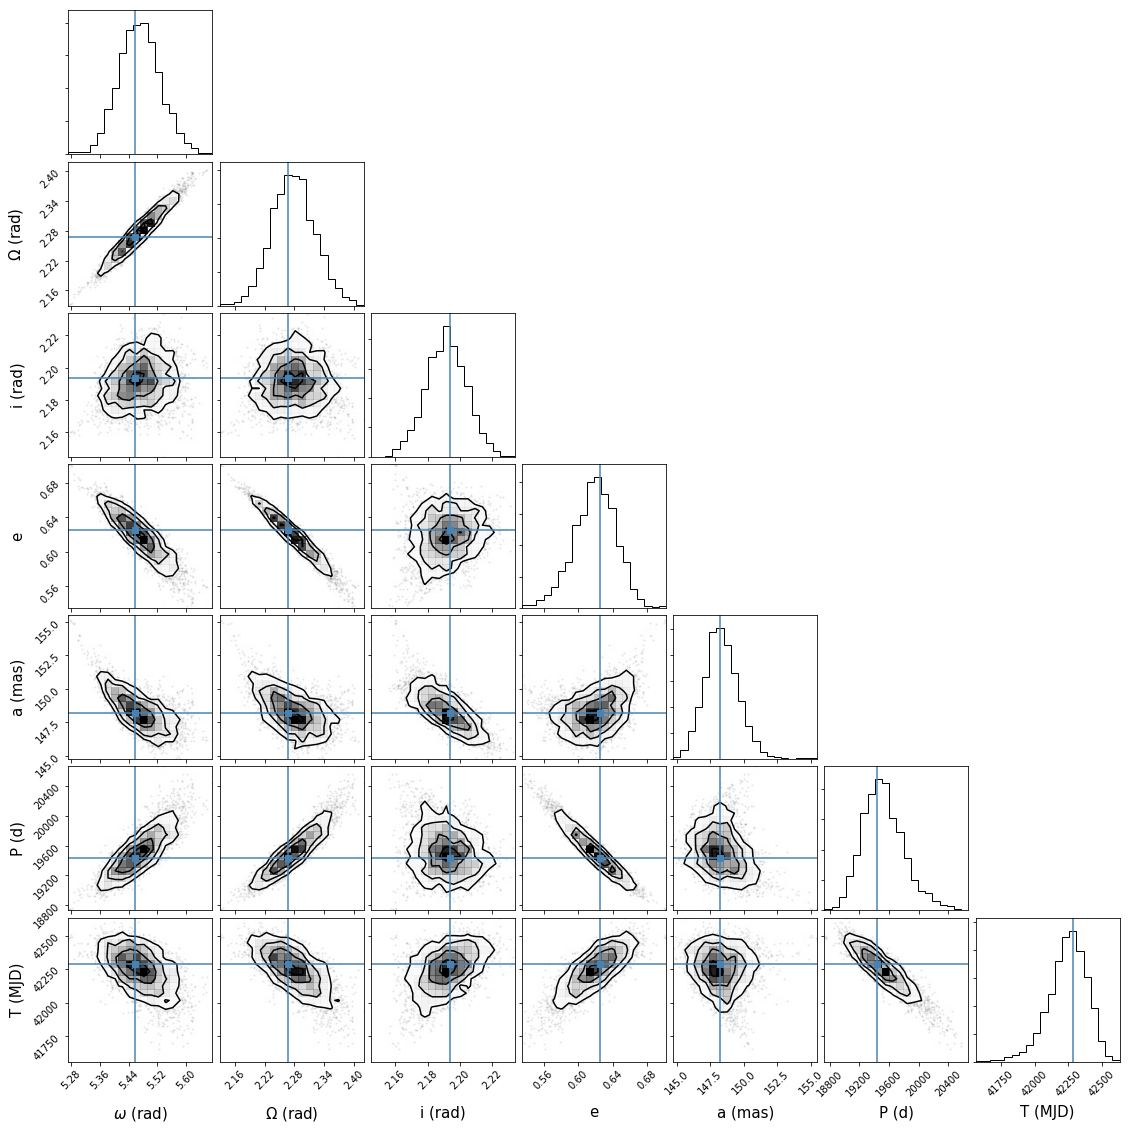

In [19]:
#samples = sampler.chain[:,burn:, :].reshape((-1, nDim));
#print("Number of posterior samples:", len(flat_samples))

fig = corner.corner(flat_samples, labels=labels,truths=initial_params,label_kwargs={"fontsize":15})
plt.savefig('%s/HD%s/HD%s_corner.pdf'%(path,target_hd,target_hd))
plt.show()

## Now we want to look at our best orbit

In [20]:
## get mean params
w_mean = np.median(flat_samples[:,0])
bigw_mean = np.median(flat_samples[:,1])
inc_mean = np.median(flat_samples[:,2])
e_mean = np.median(flat_samples[:,3])
a_mean = np.median(flat_samples[:,4])
P_mean = np.median(flat_samples[:,5])
T_mean = np.median(flat_samples[:,6])
#pscale_mean = np.median(flat_samples[:,7])

In [21]:
ra,dec,rapoints,decpoints = orbit_model(a_mean,e_mean,inc_mean,w_mean,bigw_mean,P_mean,T_mean,t_all)

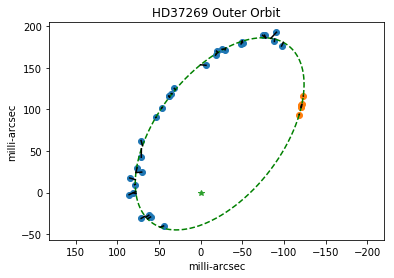

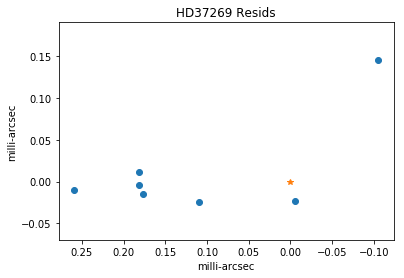

In [22]:
fig,ax=plt.subplots()

#need to measure error ellipse angle east of north
#for ras, decs, w, h, angle in zip(xpos_all,ypos_all,error_maj_all,error_min_all,error_deg_all):
#    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, angle=90-angle)#, facecolor='none')
#    ax.add_patch(ellipse)

ax.plot(xpos_wds, ypos_wds, 'o')
ax.plot(xpos,ypos,'o')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')

#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1

ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.savefig('%s/HD%s/HD%s_outer_mcmc.pdf'%(path,target_hd,target_hd))
plt.show()

## plot resids for ARMADA
fig,ax=plt.subplots()
xresid = xpos - rapoints[:len(xpos)]
yresid = ypos - decpoints[:len(ypos)]

ax.plot(xresid, yresid, 'o')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.savefig('%s/HD%s/HD%s_resid_mcmc.pdf'%(path,target_hd,target_hd))
plt.show()

## Dynamical Masses, plx